In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


<hr style="border:3px solid gray"> </hr>

<a id="data"></a> <br>
# Data





Two datasets- **Hourly** apple performances and **Daily** apple performances

In [23]:
apple_intra_df = pd.read_csv('AAPL_2015_2024_newest.csv')

In [260]:
FF_df = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV')

***

In [380]:
FF_df.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Datetime,,,,,,
1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012


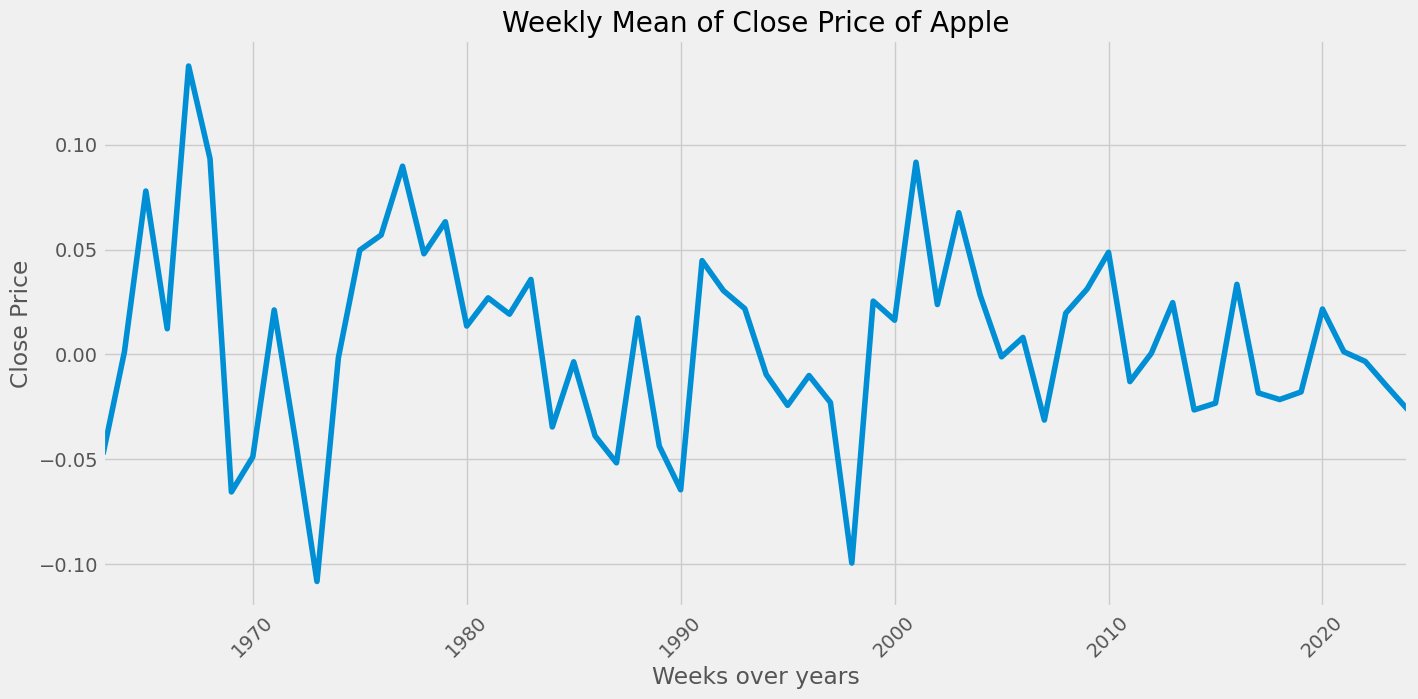

In [387]:
plt.figure(figsize = (15,7))
FF_df['SMB'].resample('y').mean().plot()
plt.title('Weekly Mean of Close Price of Apple')
plt.xticks(rotation = 45)
plt.xlabel('Weeks over years')
plt.ylabel('Close Price');

## Checking for duplcates

In [258]:
duplicated_intra = apple_intra_df[apple_intra_df.index.duplicated(keep=False)]

duplicated_FF = FF_df[FF_df.index.duplicated(keep=False)]
print('Duplicates Apple:', len(duplicated_FF), ', Duplicates FF:', len(duplicated_intra))

Duplicates Apple: 0 , Duplicates FF: 0


***

## Preprocessing

In [259]:
import numpy as np
import pandas as pd

def split_train_test(df, target_column, adjusted_column = None,train_ratio=0.7, adj_outlier = False, dropna = True):

    df = df.copy()
    if 'Unnamed: 0' in df.columns:
        df.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)
    elif 'Date' in df.columns:
        df.rename(columns={'Date': 'Datetime'}, inplace=True)


    # Convert 'Datetime' to datetime and set it as index
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

    # Create 'Return' and 'LogReturn' columns
    if adjusted_column is not None:
      df['Return'] = df[adjusted_column] - df[adjusted_column].shift(1)
      df['LogReturn'] = np.log(df[adjusted_column] / df[adjusted_column].shift(1))

    if dropna:
      df = df.dropna()
    if adj_outlier:
      rows_to_drop = df[df[target_column] < df[target_column].mean() - 5 * df[target_column].std()]
      index_to_set_as_null = rows_to_drop.index
      df.loc[index_to_set_as_null, target_column] = np.nan

    # Split into train and test sets
    n = df.shape[0]
    train_size = int(np.ceil(n * train_ratio))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    # Extract target column subsets
    train_subset = train_data[target_column]
    test_subset = test_data[target_column]

    return train_data, test_data, train_subset, test_subset, df


**There was a split in the apple stock on 2020-08-31. We'll adjust our data accordingly. It means that each stock an invester owned was split into 4**

In [47]:
apple_intra_df['Close_daily'] = np.where(apple_intra_df['Unnamed: 0'] < '2020-08-31', apple_intra_df['Close_daily']/4, apple_intra_df['Close_daily'])

In [176]:
apple_train_intra, apple_test_intra, train_subset_intra, test_subset_intra,apple_intra_df_updated  = split_train_test(apple_intra_df, 'Close_daily', 'Close_daily',train_ratio=0.7, adj_outlier = False)

***

## Matching dates between Fama & French Factors and our train set

In [261]:
FF_df.rename(columns = {'Unnamed: 0': 'Datetime'},inplace = True)
FF_df['Datetime'] = pd.to_datetime(FF_df['Datetime'], format='%Y%m%d')
FF_df.set_index('Datetime', inplace = True)
FF_df_subset = FF_df.copy()
FF_df_subset = FF_df_subset.loc['2015-01-05':]
FF_df_subset.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Datetime,,,,,,
2015-01-05,-1.84,0.25,-0.68,0.16,-0.08,0.0
2015-01-06,-1.04,-0.78,-0.31,0.53,0.02,0.0
2015-01-07,1.19,0.17,-0.66,0.25,-0.14,0.0
2015-01-08,1.81,-0.10,-0.28,0.11,-0.16,0.0
2015-01-09,-0.85,-0.02,-0.47,-0.12,-0.16,0.0


***

## Plotting Weekly mean

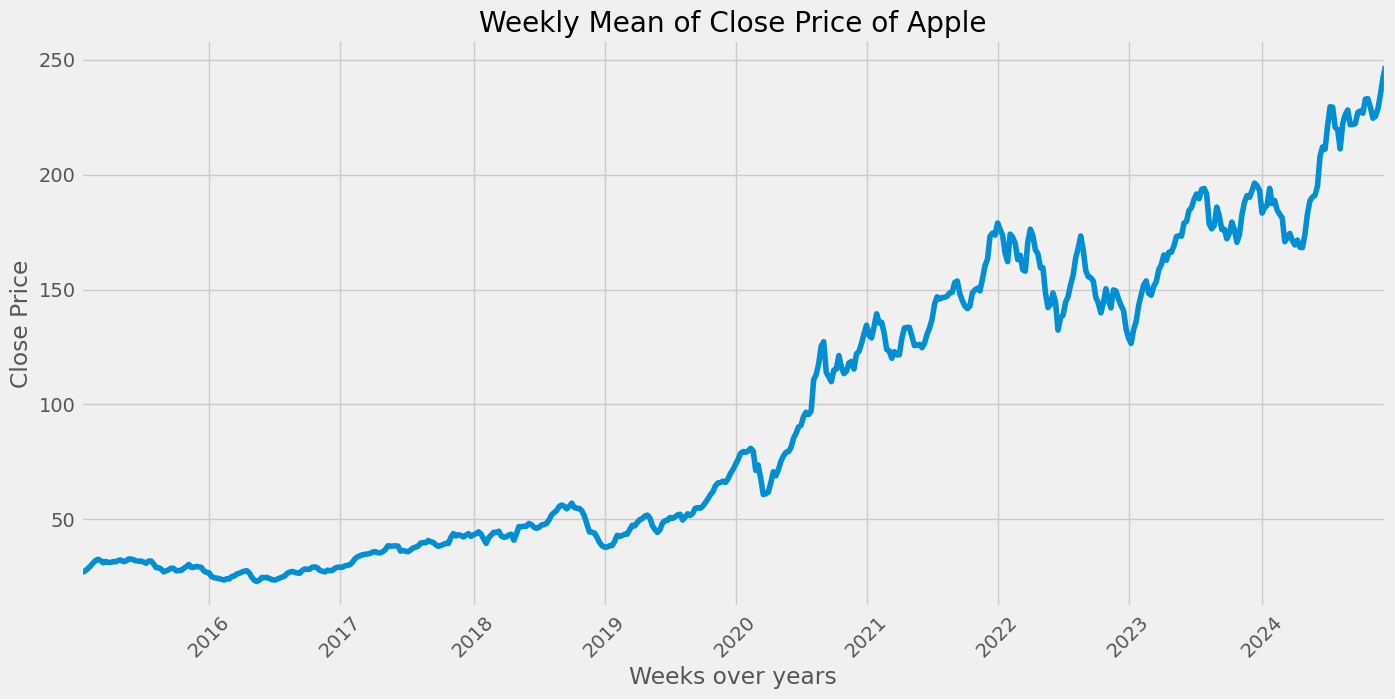

In [49]:
plt.figure(figsize = (15,7))
apple_intra_df_updated['Close_daily'].resample('W').mean().plot()
plt.title('Weekly Mean of Close Price of Apple')
plt.xticks(rotation = 45)
plt.xlabel('Weeks over years')
plt.ylabel('Close Price');

**It seems we have linear trend, we'll model our data accordingly**

## Plotting rolling mean and real close

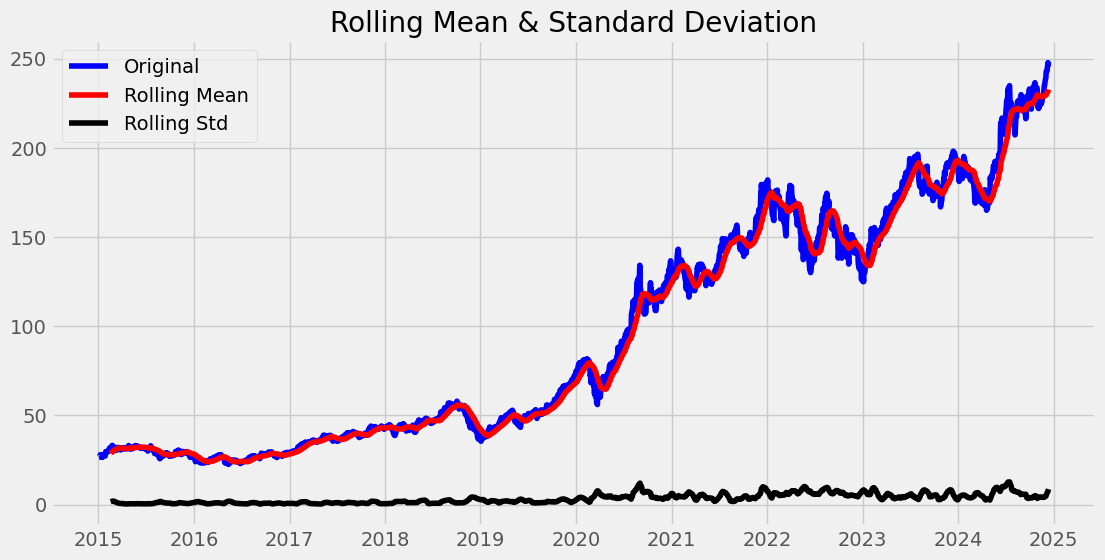

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Rolling mean and std
def plot_rolling_stats(series, window=30):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(series, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()


plot_rolling_stats(apple_intra_df_updated['Close_daily'])


***

## Renaming columns for prophet

In [342]:
def preprocess_for_prophet(df, index_column='index', rename_columns=None):

    if rename_columns is None:
        rename_columns = {}
    return df.reset_index().rename(columns=rename_columns)


train_subset_intra = preprocess_for_prophet(train_subset_intra, rename_columns={'Datetime': 'ds', 'Close_daily': 'y'})
test_subset_intra = preprocess_for_prophet(test_subset_intra, rename_columns={'Datetime': 'ds', 'Close_daily': 'y'})


train_data_regres = pd.merge(train_subset_intra, FF_df_subset.reset_index(), left_on='ds', right_on='Datetime', how='inner')
test_data_regres = pd.merge(test_subset_intra, FF_df_subset.reset_index(), left_on='ds', right_on='Datetime', how='inner')

In [338]:
test_data_regres.head()

,index,ds,y,Datetime,Mkt-RF,SMB,HML,RMW,CMA,RF
0,0,2021-12-20,169.75,2021-12-20,-1.27,-0.23,-0.40,0.04,0.15,0.0
1,1,2021-12-21,172.99,2021-12-21,2.06,0.67,0.20,-1.08,-0.20,0.0
2,2,2021-12-22,175.64,2021-12-22,0.97,0.18,-0.36,0.34,0.07,0.0
3,3,2021-12-23,176.28,2021-12-23,0.71,0.29,-0.48,-0.36,-0.39,0.0
4,4,2021-12-27,180.33,2021-12-27,1.22,-0.14,0.31,0.98,0.48,0.0


***

<div class="alert alert-block alert-info">
<b>Note:</b> We're going to compare a baseline model for daily returns, to model with added regressor and added events.
</div>

<hr style="border:3px solid gray"> </hr>

<a id="apple-daily-stock"></a><br>

# Apple Daily Stock

## Daily Apple Model

In [86]:
model_apple_intra = Prophet(weekly_seasonality=False, daily_seasonality=False)  # Disable default weekly seasonality


model_apple_intra.add_seasonality(name='weekday_only', period=5, fourier_order=3)  # Custom 5-day period

model_apple_intra.fit(train_subset_intra)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxry85yes/0hedyja3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxry85yes/2vqke8js.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23214', 'data', 'file=/tmp/tmpxry85yes/0hedyja3.json', 'init=/tmp/tmpxry85yes/2vqke8js.json', 'output', 'file=/tmp/tmpxry85yes/prophet_modelm_w7vbbf/prophet_model-20250118105158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:51:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [87]:
apple_preds_intra = model_apple_intra.predict(test_subset_intra)

### Model compomemts

## Trend and yearly

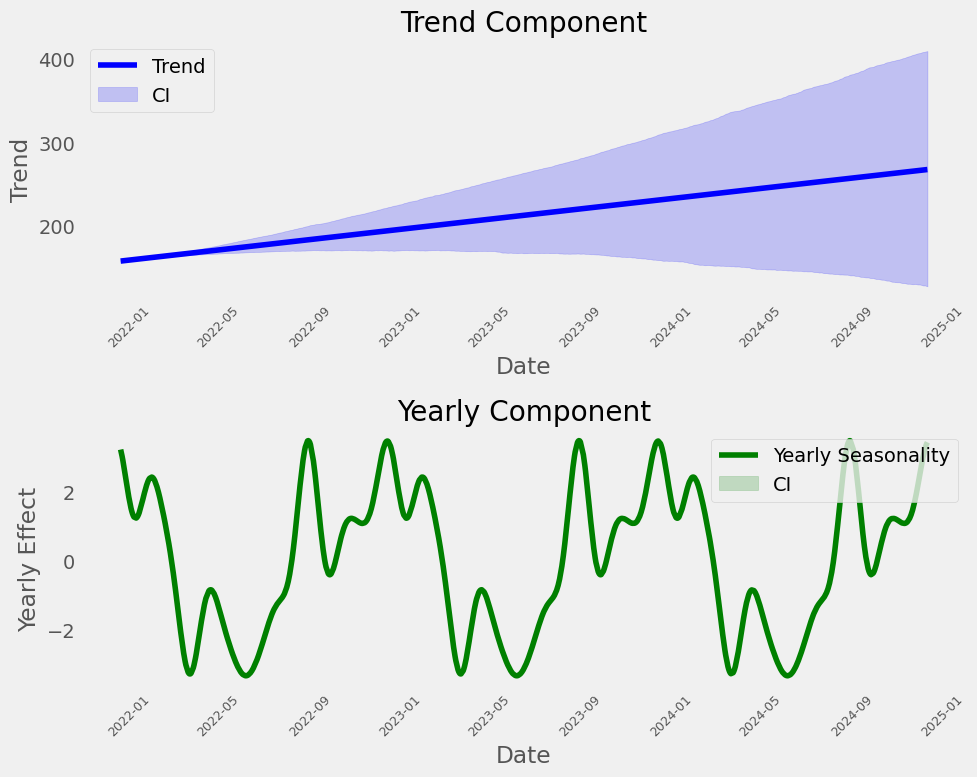

In [300]:
import matplotlib.pyplot as plt

# Extract specific components and their confidence intervals
trend = apple_preds_intra[['ds', 'trend', 'trend_lower', 'trend_upper']]
yearly = apple_preds_intra[['ds', 'yearly', 'yearly_lower', 'yearly_upper']]

# Create a figure to mimic the multi-component layout of plot_components
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot trend with confidence intervals
axes[0].plot(trend['ds'], trend['trend'], label='Trend', color='blue')
axes[0].fill_between(trend['ds'], trend['trend_lower'], trend['trend_upper'], color='blue', alpha=0.2, label='CI')
axes[0].set_title('Trend Component')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Trend')
axes[0].grid()
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45, labelsize=9)

# Plot yearly seasonality with confidence intervals
axes[1].plot(yearly['ds'], yearly['yearly'], label='Yearly Seasonality', color='green')
axes[1].fill_between(yearly['ds'], yearly['yearly_lower'], yearly['yearly_upper'], color='green', alpha=0.2, label='CI')
axes[1].set_title('Yearly Component')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Yearly Effect')
axes[1].grid()
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45, labelsize=9)


# Adjust layout
plt.tight_layout()
plt.show()


## Customized 5 day weekly

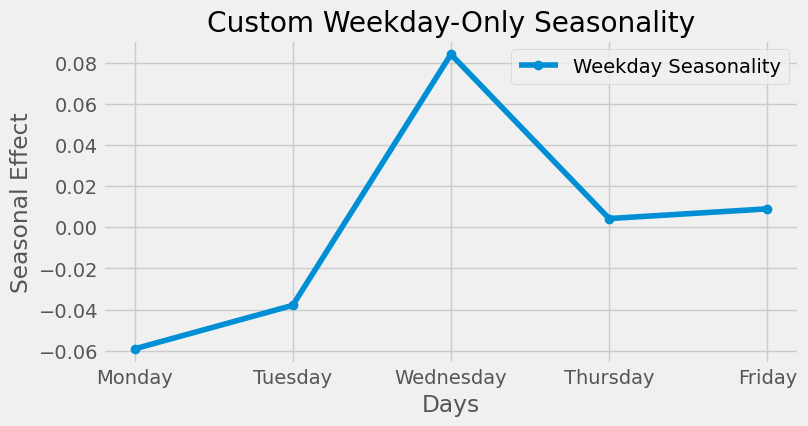

In [301]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the weekday-only seasonality component
days = np.arange(0, 5)  # Monday (0) to Friday (4)
seasonality = model_apple_intra.predict_seasonal_components(pd.DataFrame({
    'ds': pd.date_range(start=test_data_regres.index.min(), periods=5, freq='D')  # Monday to Friday
}))['weekday_only']

# Plot the seasonality for weekdays
plt.figure(figsize=(8, 4))
plt.plot(days, seasonality, marker='o', label='Weekday Seasonality')
plt.xticks(days, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.xlabel('Days')
plt.ylabel('Seasonal Effect')
plt.title('Custom Weekday-Only Seasonality')
plt.legend()
plt.grid(True)
plt.show()


**We can infer from the plots about the overall trend and seasonality**

## Forecast

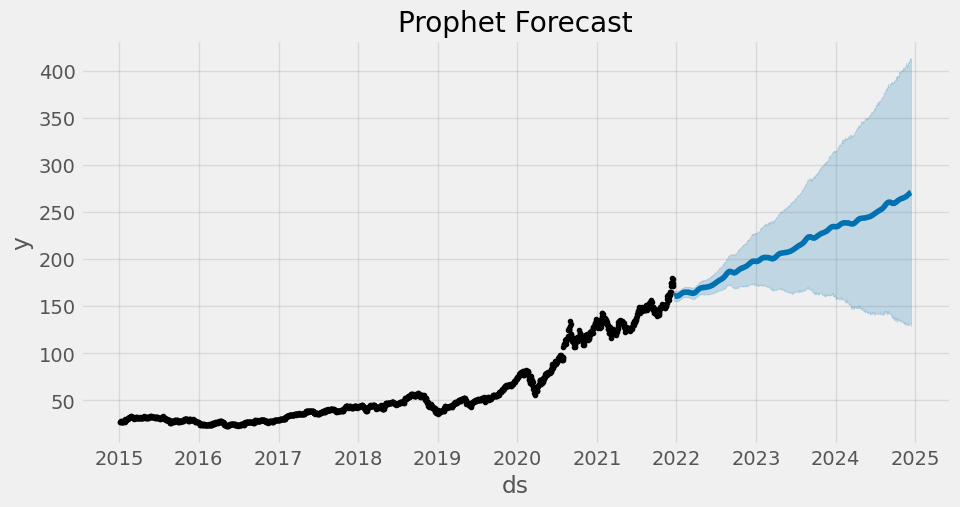

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

## Real Return values vs predicted Returns

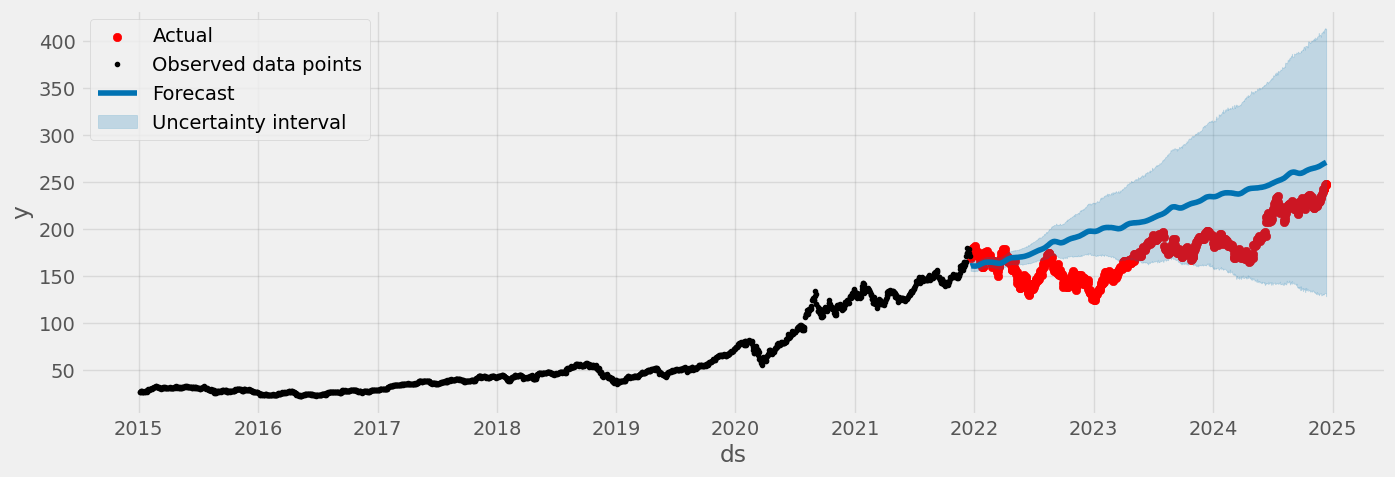

In [90]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Close_daily'], color = 'r', label = 'Actual')
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
plt.legend()

*We can see the overall trend. It seems that over time the stock becomes more volatile. Our CI fairly covers the actual prediction but our mean prediction can be better*

### Test dates

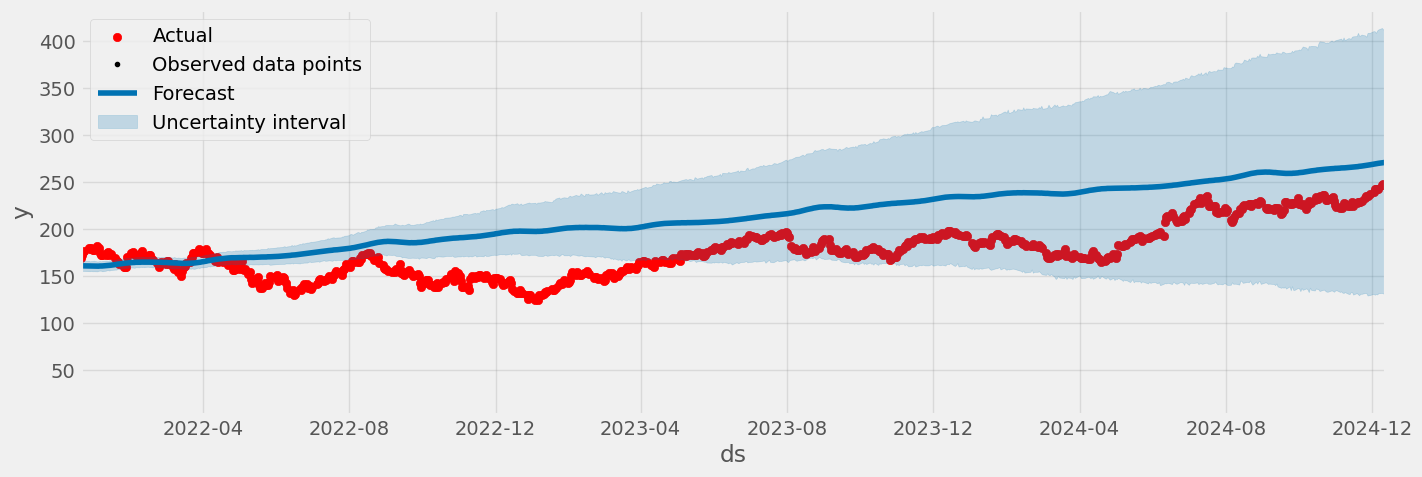

In [302]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Close_daily'], color = 'r', label = 'Actual')
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
ax.set_xbound(lower=apple_test_intra.index.min(),
              upper=apple_test_intra.index.max())
plt.legend()

### Preds histogram

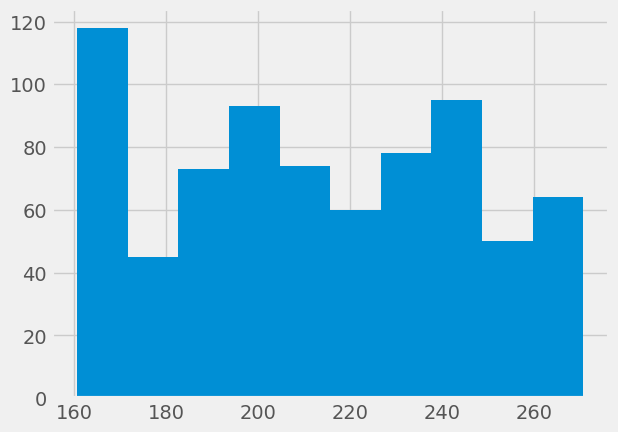

In [92]:
plt.hist(apple_preds_intra['yhat']);

*Seems close to normal distribution, close to symmetric*

## Future Predictions

In [93]:
from pandas.tseries.offsets import CustomBusinessDay

# Define a custom business day (weekdays only)
business_days = CustomBusinessDay()

# Generate future dates excluding weekends for 5 years
future_dates = pd.date_range(
    start=apple_test_intra.index.max() + pd.Timedelta(days=1),  # Start after last test date
    periods=3 * 261,  # Approximate business days in 5 years (252/year)
    freq=business_days
)

# Create the future DataFrame manually
future_intra = pd.DataFrame({'ds': future_dates})

# Use this DataFrame for predictions
forecast_intra = model_apple_intra.predict(future_intra)


In [ ]:
forecast_intra.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-12-13,270.575051,270.868506,282.943640,270.575051,270.575051,6.654224,6.654224,6.654224,3.246401,...,0.133684,0.133684,0.133684,3.274138,3.274138,3.274138,0.0,0.0,0.0,277.229275
1,2024-12-16,270.893071,271.193044,283.139603,270.893071,270.893071,6.327903,6.327903,6.327903,3.246401,...,-0.137800,-0.137800,-0.137800,3.219301,3.219301,3.219301,0.0,0.0,0.0,277.220973
2,2024-12-17,270.999077,271.491982,283.692575,270.999077,270.999077,6.685819,6.685819,6.685819,3.246401,...,0.270141,0.270141,0.270141,3.169277,3.169277,3.169277,0.0,0.0,0.0,277.684897
3,2024-12-18,271.105084,271.740261,283.818220,271.105084,271.105084,6.645125,6.645125,6.645125,3.246401,...,0.294540,0.294540,0.294540,3.104183,3.104183,3.104183,0.0,0.0,0.0,277.750209
4,2024-12-19,271.211090,271.638064,283.550197,271.211090,271.211090,6.522293,6.522293,6.522293,3.246401,...,0.251035,0.251035,0.251035,3.024857,3.024857,3.024857,0.0,0.0,0.0,277.733384
5,2024-12-20,271.317097,271.552558,283.449985,271.317097,271.317097,6.312448,6.312448,6.312448,3.246401,...,0.133684,0.133684,0.133684,2.932363,2.932363,2.932363,0.0,0.0,0.0,277.629545
6,2024-12-23,271.635117,271.487652,282.935009,271.635117,271.635117,5.698094,5.698094,5.698094,3.246401,...,-0.137800,-0.137800,-0.137800,2.589493,2.589493,2.589493,0.0,0.0,0.0,277.333211
7,2024-12-24,271.741123,271.748713,284.170370,271.741123,271.741123,5.975333,5.975333,5.975333,3.246401,...,0.270141,0.270141,0.270141,2.458791,2.458791,2.458791,0.0,0.0,0.0,277.716457
8,2024-12-25,271.847130,271.943157,283.531213,271.847130,271.847130,5.863845,5.863845,5.863845,3.246401,...,0.294540,0.294540,0.294540,2.322904,2.322904,2.322904,0.0,0.0,0.0,277.710975
9,2024-12-26,271.953136,271.488590,283.119228,271.953136,271.953136,5.681211,5.681211,5.681211,3.246401,...,0.251035,0.251035,0.251035,2.183775,2.183775,2.183775,0.0,0.0,0.0,277.634347


### Plot actual vs forecast vs future predictions

In [98]:
future = model_apple_intra.make_future_dataframe(periods=1826)
future_preds = model_apple_intra.predict(future)
future_close = future_preds[future_preds['ds'] > apple_test_intra.index.max()]



In [111]:
future_close.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekday_only,weekday_only_lower,weekday_only_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3574,2026-12-13,341.090981,46.795087,668.978291,43.488468,667.324879,3.373173,3.373173,3.373173,-0.059115,-0.059115,-0.059115,3.432288,3.432288,3.432288,0.0,0.0,0.0,344.464154
3575,2026-12-14,341.191790,46.448930,671.828774,43.486591,667.857112,3.413218,3.413218,3.413218,-0.037969,-0.037969,-0.037969,3.451188,3.451188,3.451188,0.0,0.0,0.0,344.605008
3576,2026-12-15,341.292598,44.602012,667.466584,43.484715,668.389344,3.538125,3.538125,3.538125,0.083987,0.083987,0.083987,3.454138,3.454138,3.454138,0.0,0.0,0.0,344.830722
3577,2026-12-16,341.393406,44.828477,671.955367,43.482838,668.844140,3.445050,3.445050,3.445050,0.004199,0.004199,0.004199,3.440851,3.440851,3.440851,0.0,0.0,0.0,344.838456
3578,2026-12-17,341.494214,43.715757,672.310620,43.480962,669.000285,3.420200,3.420200,3.420200,0.008898,0.008898,0.008898,3.411303,3.411303,3.411303,0.0,0.0,0.0,344.914414


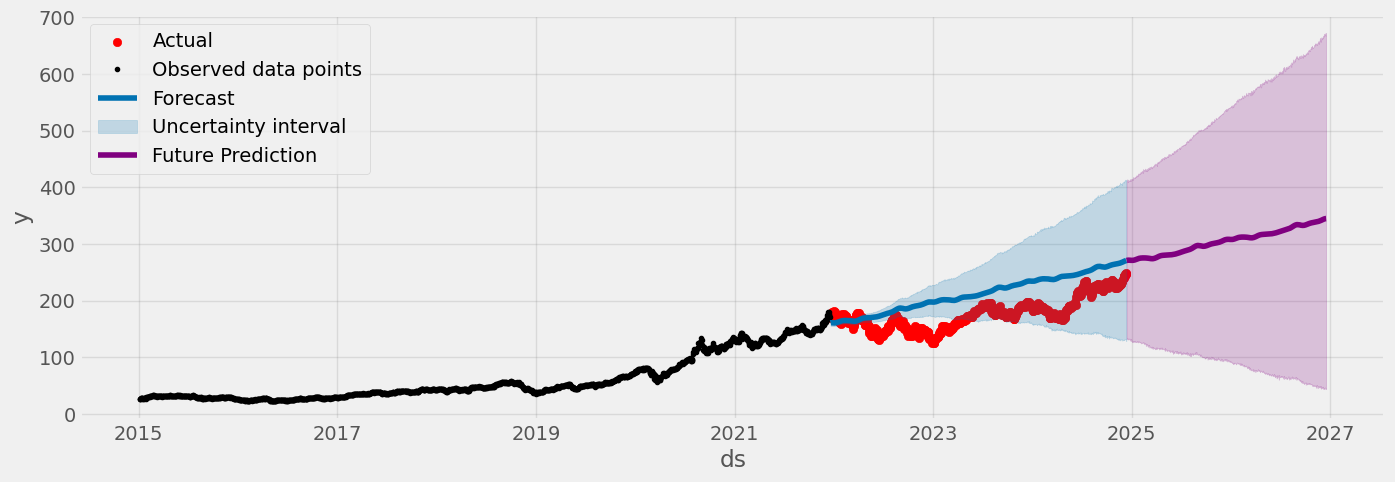

In [113]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Close_daily'], color = 'r', label = 'Actual')
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
sns.lineplot(x = future_close['ds'],y = future_close['yhat'], color = 'purple',label='Future Prediction')
ax.fill_between(
    future_close['ds'].values,
    future_close['yhat_lower'],
    future_close['yhat_upper'],
    color='purple',
    alpha=0.2,
)


plt.legend(loc = 'upper left')

**We can see the predicted future Close values. We'll add the there might be a split again if we reach high values**

## Evaluate

In [102]:
from sklearn.metrics import mean_squared_error
mse_intra_apple = mean_squared_error(test_subset_intra['y'],apple_preds_intra['yhat'])
mse_intra_apple

1672.2802825425174

### Error analysis

In [ ]:
train_subset_intra['ds'].max() - train_subset_intra['ds'].min()

Timedelta('2538 days 00:00:00')

In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model_apple_intra, initial='730 days', period='30 days', horizon = '365 days')


### Error Metrics

The article suggested using **smape** but we can choose the relevant metrics to focus on

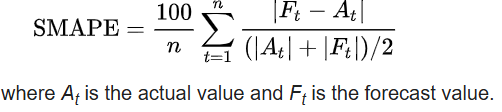

In [369]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,61.551931,7.845504,5.579542,0.092260,0.074836,0.091970,0.272913
1,38 days,62.857872,7.928296,5.643346,0.093347,0.075265,0.093071,0.266759
2,39 days,64.427524,8.026676,5.719557,0.094434,0.076178,0.094167,0.260695
3,40 days,65.809749,8.112321,5.787367,0.095481,0.077612,0.095177,0.257001
4,41 days,67.320351,8.204898,5.866602,0.096610,0.078346,0.096299,0.252841


### Plotting smape metric over different windows

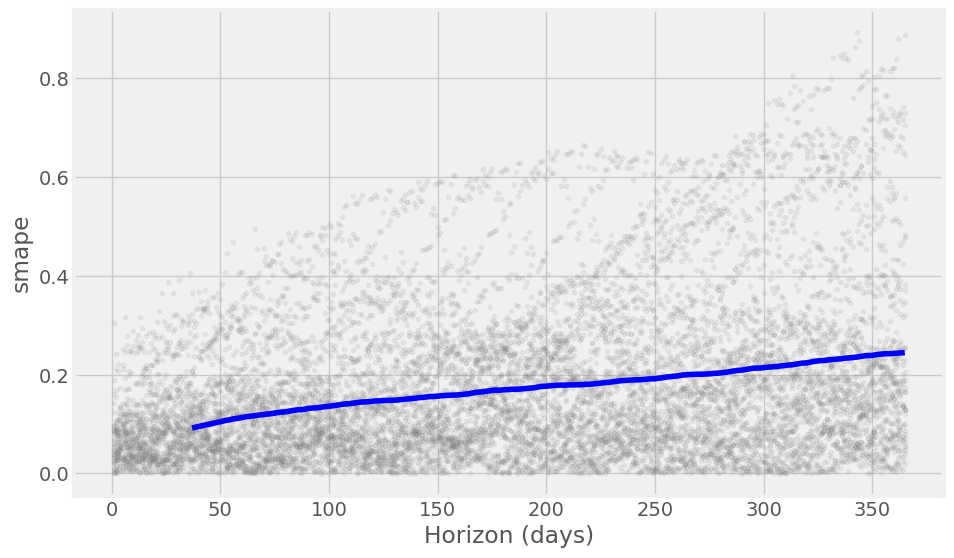

In [370]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='smape');


**Seems like the model doesn't have problematic windows when looking at monthly prediction. Can be investigated further**



### Uncertainty measuring

Instead of finding the MAP we're running full Baseyian inference

In [ ]:
m = Prophet(mcmc_samples=300)
forecast = m.fit(train_subset_intra, show_progress=True).predict(future_intra)


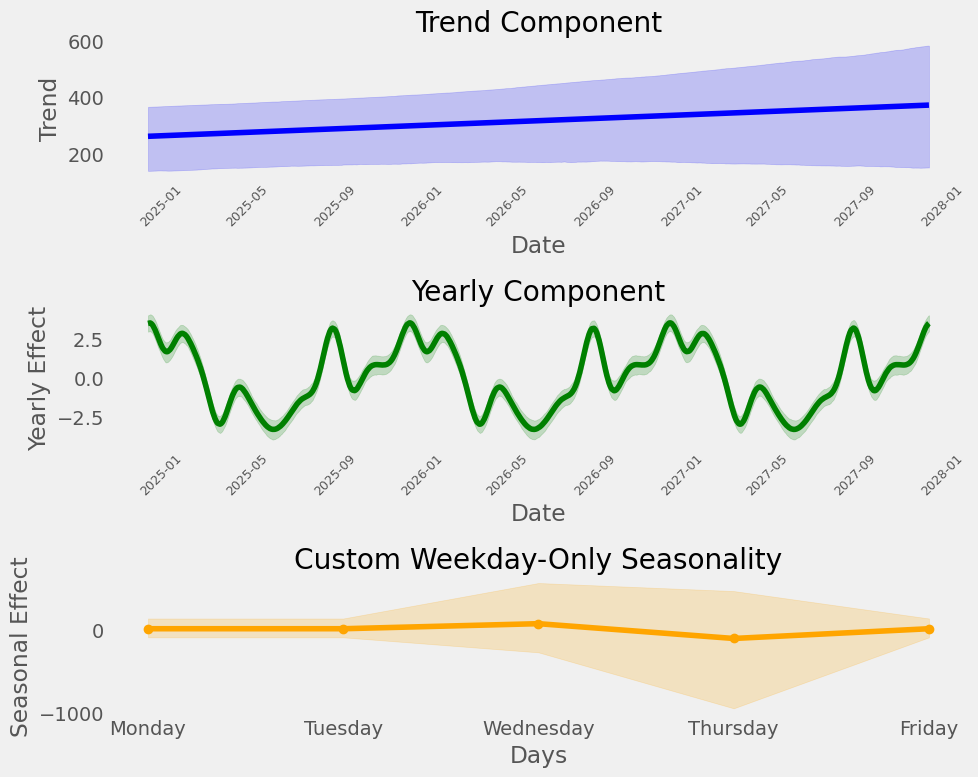

In [324]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

trend = forecast[['ds', 'trend', 'trend_lower', 'trend_upper']]
yearly = forecast[['ds', 'yearly', 'yearly_lower', 'yearly_upper']]

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

axes[0].plot(trend['ds'], trend['trend'], label='Trend', color='blue')
axes[0].fill_between(trend['ds'], trend['trend_lower'], trend['trend_upper'], color='blue', alpha=0.2, label='CI')
axes[0].set_title('Trend Component')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Trend')
axes[0].grid()
axes[0].tick_params(axis='x', rotation=45, labelsize=9)

axes[1].plot(yearly['ds'], yearly['yearly'], label='Yearly Seasonality', color='green')
axes[1].fill_between(yearly['ds'], yearly['yearly_lower'], yearly['yearly_upper'], color='green', alpha=0.2, label='CI')
axes[1].set_title('Yearly Component')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Yearly Effect')
axes[1].grid()
axes[1].tick_params(axis='x', rotation=45, labelsize=9)

start_date = test_data_regres.index.min()

df_future_weekdays = pd.DataFrame({
    'ds': pd.date_range(start=start_date, periods=5, freq='D')
})

seasonality = m.predict_seasonal_components(df_future_weekdays)

days = np.arange(5)

axes[2].plot(days, seasonality['weekly'], marker='o', label='Weekday Seasonality', color='orange')


axes[2].fill_between(days, seasonality['weekly_lower'], seasonality['weekly_upper'], color='orange', alpha=0.2, label='CI')

axes[2].set_xticks(days)
axes[2].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Seasonal Effect')
axes[2].set_title('Custom Weekday-Only Seasonality')
axes[2].grid()


plt.tight_layout()
plt.show()


**This way we can quantify the model's uncertainty**




<hr style="border:3px solid gray"> </hr>

# Apple daily with added regressors

## Model With added regressors

In [191]:
model_regres = Prophet(weekly_seasonality=False, daily_seasonality=False)
model_regres.add_seasonality(name='weekday_only', period=5, fourier_order=3)  # Custom 5-day period


# Add regressors dynamically
for regressor in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']: # Fama & French 5 factors
    model_regres.add_regressor(regressor,standardize = False)

model_regres.fit(train_data_regres)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxry85yes/sbdx65id.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxry85yes/s0ocrrhk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=619', 'data', 'file=/tmp/tmpxry85yes/sbdx65id.json', 'init=/tmp/tmpxry85yes/s0ocrrhk.json', 'output', 'file=/tmp/tmpxry85yes/prophet_modelq6275br4/prophet_model-20250118123346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:33:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:33:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [192]:
stock_regress_preds = model_regres.predict(test_data_regres)

## Plot components (without the regressors)

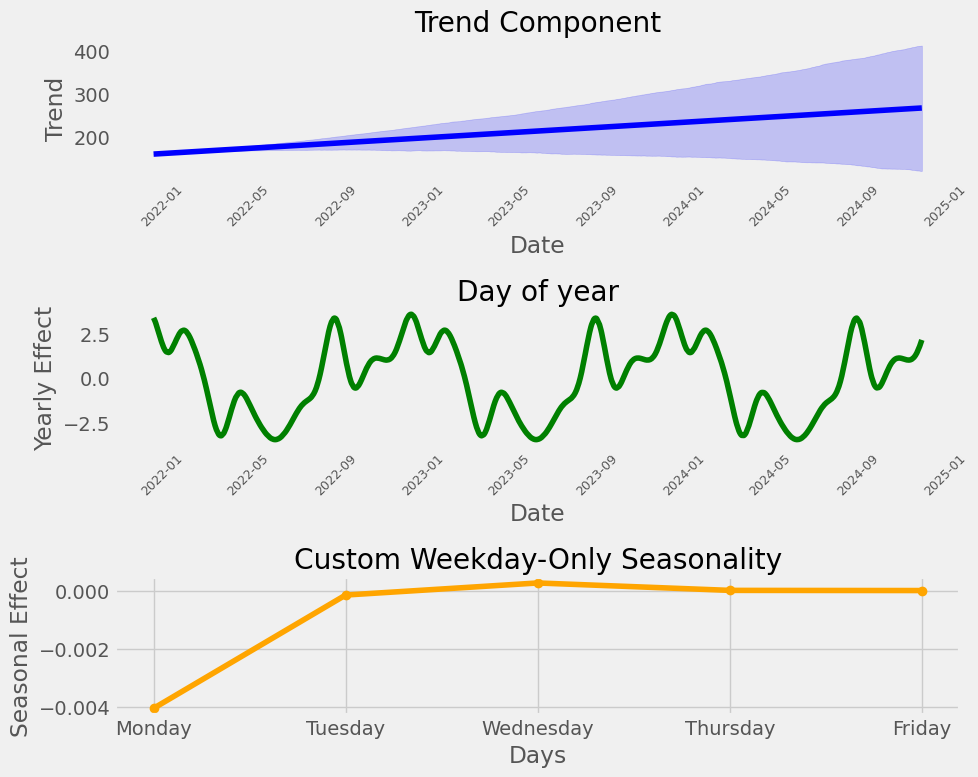

In [297]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract specific components and their confidence intervals
trend = stock_regress_preds[['ds', 'trend', 'trend_lower', 'trend_upper']]
yearly = stock_regress_preds[['ds', 'yearly', 'yearly_lower', 'yearly_upper']]

# Create a figure to mimic the multi-component layout of plot_components
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Plot trend with confidence intervals
axes[0].plot(trend['ds'], trend['trend'], label='Trend', color='blue')
axes[0].fill_between(trend['ds'], trend['trend_lower'], trend['trend_upper'], color='blue', alpha=0.2, label='CI')
axes[0].set_title('Trend Component')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Trend')
axes[0].set_yticks([200, 300, 400])
axes[0].grid()
axes[0].tick_params(axis='x', rotation=45, labelsize=9)

# Plot yearly seasonality with confidence intervals
axes[1].plot(yearly['ds'], yearly['yearly'], label='Yearly Seasonality', color='green')
axes[1].fill_between(yearly['ds'], yearly['yearly_lower'], yearly['yearly_upper'], color='green', alpha=0.2, label='CI')
axes[1].set_title('Day of year')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Yearly Effect')
axes[1].grid()
axes[1].tick_params(axis='x', rotation=45, labelsize=9)

# Extract the weekday-only seasonality component
days = np.arange(0, 5)  # Monday (0) to Friday (4)

seasonality = stock_regress_preds.groupby(stock_regress_preds['ds'].dt.weekday)['weekday_only'].mean()

# Plot the seasonality for weekdays
axes[2].plot(days, seasonality, marker='o', label='Weekday Seasonality', color='orange')
axes[2].set_xticks(days)  # Set the positions of the ticks
axes[2].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])  # Set the tick labels
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Seasonal Effect')
axes[2].set_title('Custom Weekday-Only Seasonality')

# Adjust layout
plt.tight_layout()
plt.show()


## Forecast

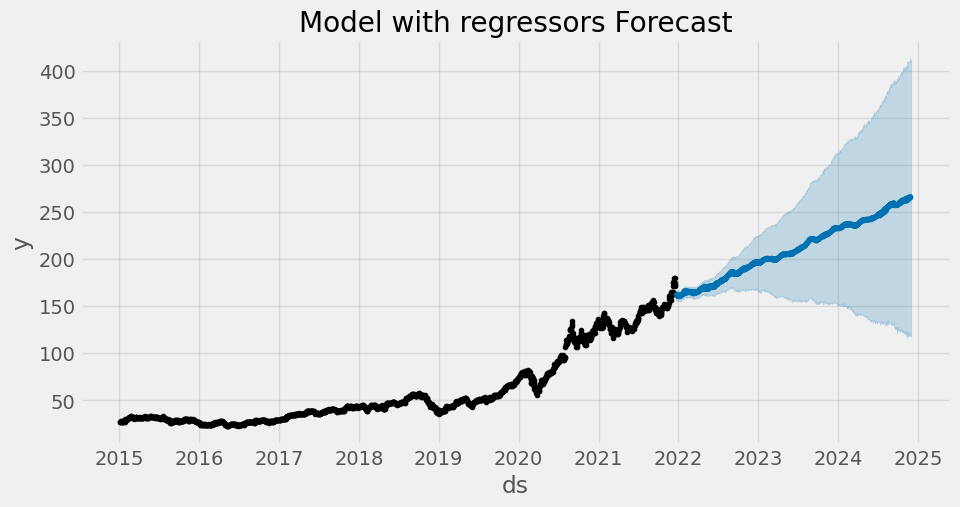

In [373]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_regres.plot(stock_regress_preds, ax=ax)
ax.set_title('Model with regressors Forecast')
plt.show()

## Forecast vs actual Close results

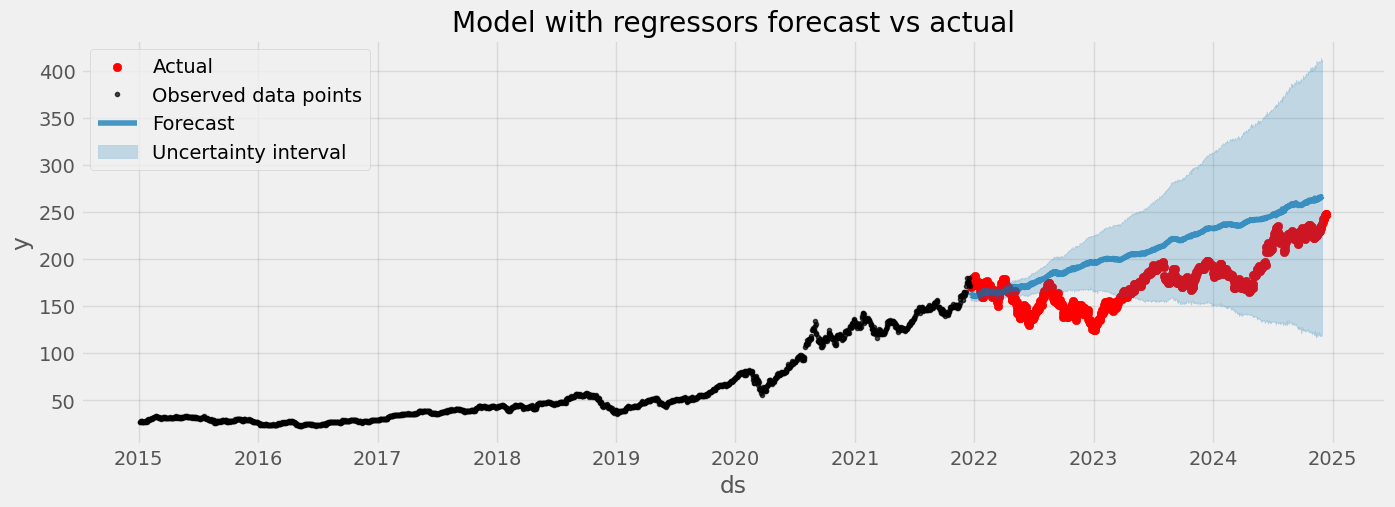

In [372]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Close_daily'], color = 'r',label = 'Actual')
fig = model_regres.plot(stock_regress_preds, ax=ax)
# Adjust the alpha for the prediction intervals manually
for line in fig.gca().get_lines():
    line.set_alpha(0.7)

plt.title('Model with regressors forecast vs actual')

plt.legend()

### Test dates

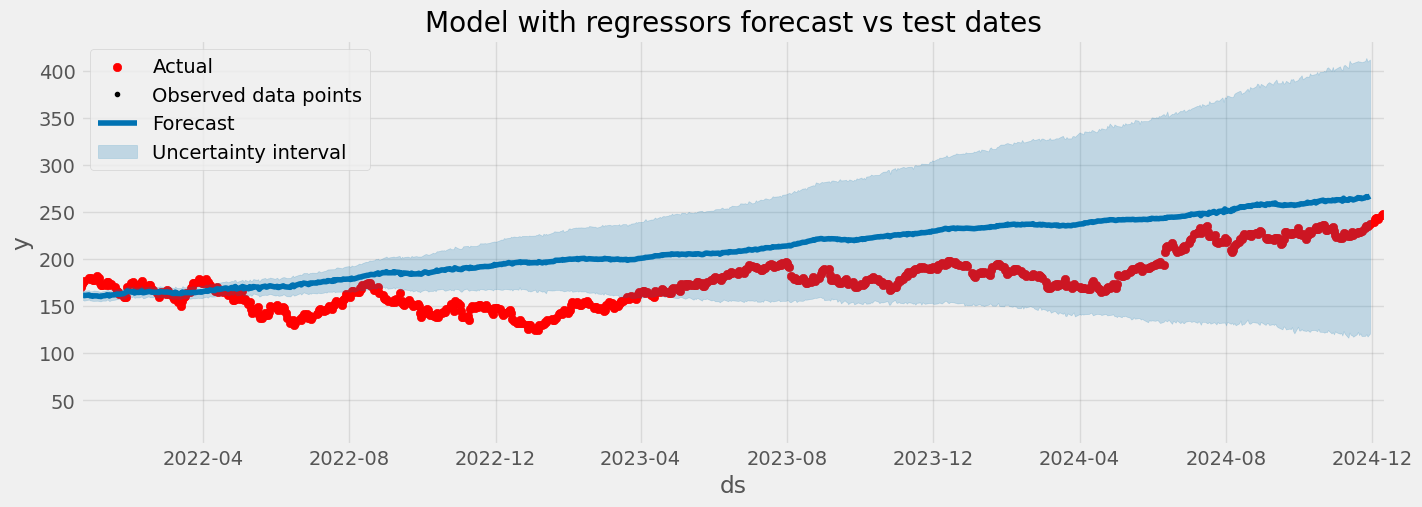

In [374]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Close_daily'], color = 'r',label = 'Actual')
fig = model_regres.plot(stock_regress_preds, ax=ax)
ax.set_xbound(lower=apple_test_intra.index.min(),
              upper=apple_test_intra.index.max())
plt.title('Model with regressors forecast vs test dates')
plt.legend()

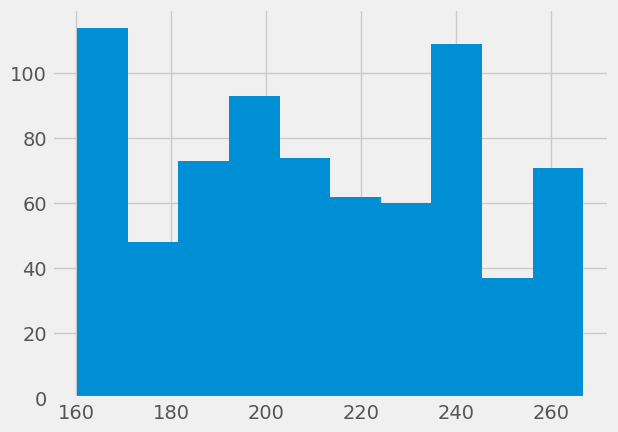

In [201]:
plt.hist(stock_regress_preds['yhat']);

## Finding future factors using Prophet model

**Running over each factor and finding future values using Prophet model:**

In [389]:
# Prepare Fama & French regressors
factors = ['Mkt-RF', 'SMB', 'HML', 'RF', 'RMW', 'CMA']
future_factors = {}
FF_df = FF_df.reset_index().rename(columns={'Datetime': 'ds'})
for factor in factors:
    ff_model = Prophet(daily_seasonality=False, weekly_seasonality=False) # Looking at yearly seasonality since it looks that the factors have yearly trend
    historical_data = FF_df[['ds', factor]].rename(columns={factor: 'y'})
    ff_model.fit(historical_data)
    future = ff_model.make_future_dataframe(periods=1826)
    forecast = ff_model.predict(future)
    future_factors[factor] = forecast[['ds', 'yhat']].rename(columns={'yhat': factor})

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxry85yes/65vazwhv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxry85yes/fv0wc94i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40452', 'data', 'file=/tmp/tmpxry85yes/65vazwhv.json', 'init=/tmp/tmpxry85yes/fv0wc94i.json', 'output', 'file=/tmp/tmpxry85yes/prophet_model4j_2gwjn/prophet_model-20250118172929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxry85yes/95f2k_cc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxry85yes/h50ztxh0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/py

In [390]:
# Ensure the max date in apple_test_intra.index is in datetime format
max_date = pd.to_datetime(apple_test_intra.index.max())

# Filter each DataFrame in the dictionary for dates beyond max_date
future_close = {}
for factor, df in future_factors.items():
    future_close[factor] = df[df['ds'] > max_date]


In [391]:
# Initialize the DataFrame with the first factor
future_close_df = future_close[list(future_close.keys())[0]]

# Merge other factors
for factor, df in future_close.items():
    if factor != list(future_close.keys())[0]:
        future_close_df = future_close_df.merge(df, on='ds', how='outer', suffixes=('', f'_{factor}'))


In [392]:
future_preds = model_regres.predict(future_close_df)

## Plotting Actual values vs Forecast vs Future predictions

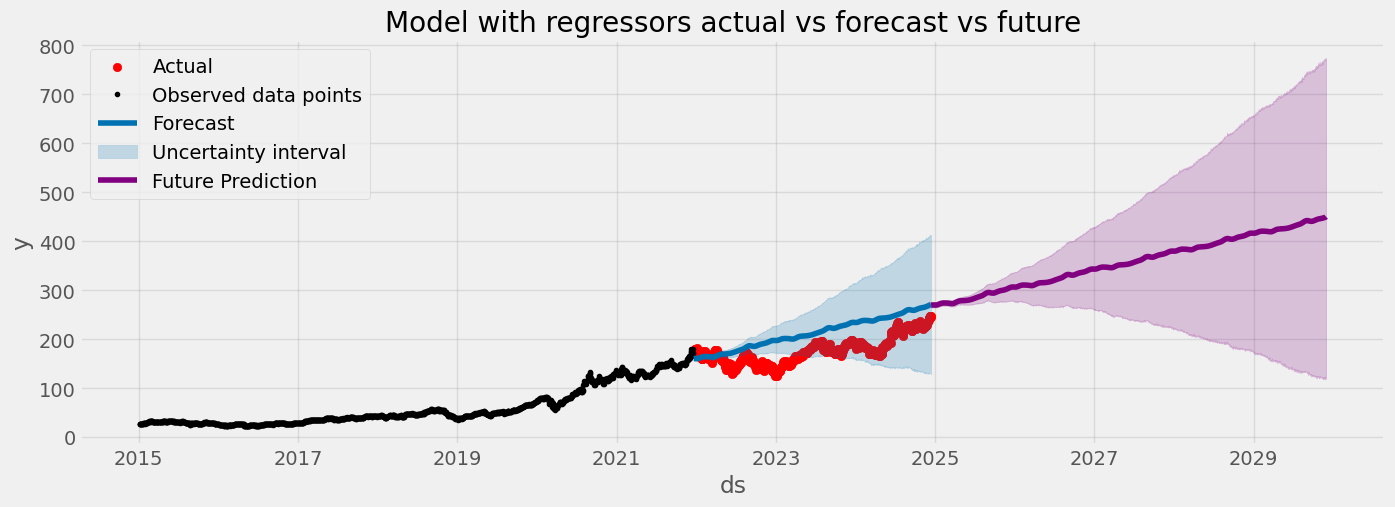

In [393]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Close_daily'], color = 'r', label = 'Actual')
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
sns.lineplot(x = future_preds['ds'],y = future_preds['yhat'], color = 'purple',label='Future Prediction')
ax.fill_between(
    future_preds['ds'].values,
    future_preds['yhat_lower'],
    future_preds['yhat_upper'],
    color='purple',
    alpha=0.2,
)

plt.title('Model with regressors actual vs forecast vs future')
plt.legend(loc = 'upper left')

**After finding future values of F&F factors we can predict future with higher certainty. We can explore different models than Prophet as well**

## Evaluating

In [306]:
from sklearn.metrics import mean_squared_error
mse_intra_apple_regres = mean_squared_error(test_data_regres['y'],stock_regress_preds['yhat'])
mse_intra_apple_regres

1562.3265608821941

*Better than our baseline model, we'll go back to it*

### Error analysis

In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model_regres, initial='730 days', period='30 days', horizon = '365 days')


In [362]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,61.323263,7.830917,5.564154,0.091803,0.073920,0.091373,0.268460
1,38 days,62.733933,7.920476,5.633627,0.092999,0.074387,0.092576,0.261889
2,39 days,64.229654,8.014341,5.712386,0.094140,0.075474,0.093742,0.255204
3,40 days,65.592355,8.098911,5.783650,0.095262,0.076429,0.094820,0.249696
4,41 days,67.140689,8.193942,5.862893,0.096409,0.077271,0.095943,0.245130


### Plotting smape metric over different windows

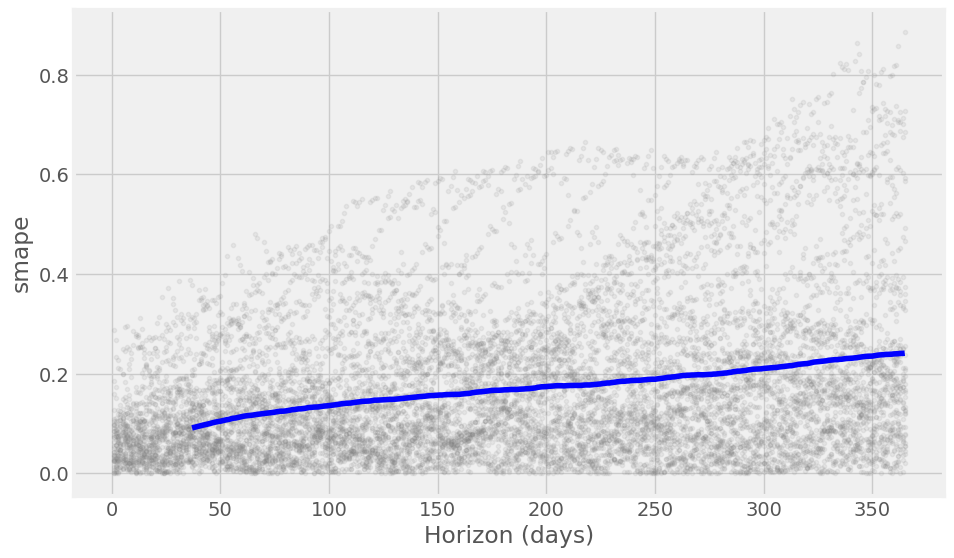

In [363]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='smape');


**Seems like the model doesn't have problematic windows when looking at monthly prediction. Can be investigated further**




### Uncertainty measuring

Instead of finding the MAP we're running full Baseyian inference

In [ ]:
m = Prophet(mcmc_samples=300)
forecast = m.fit(train_data_regres, show_progress=True).predict(future_intra)


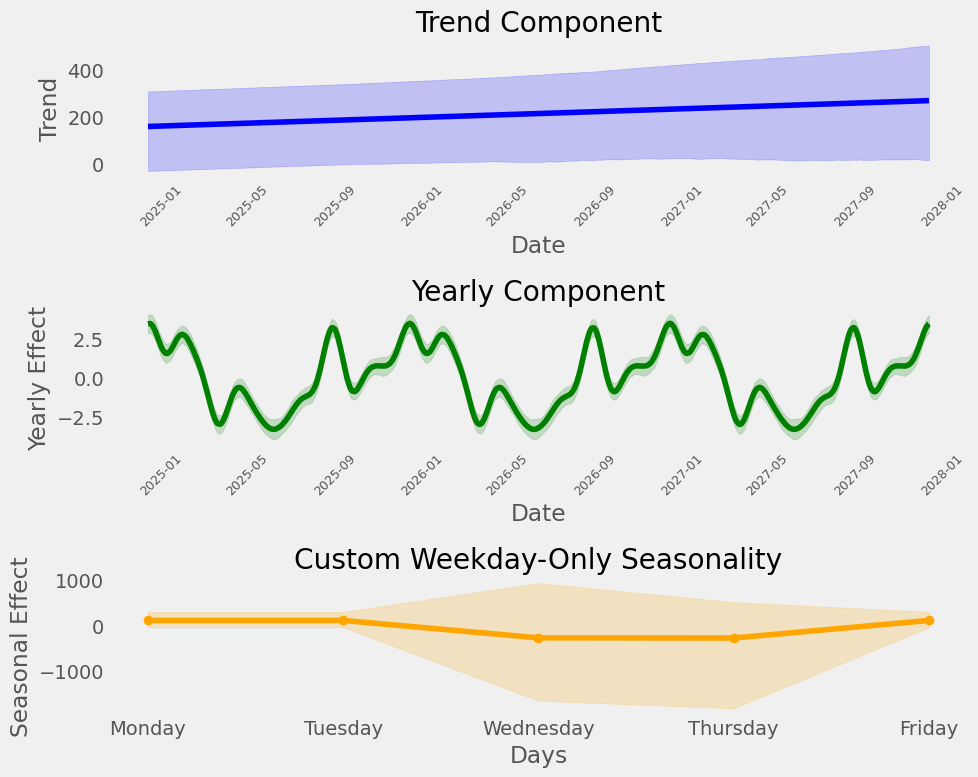

In [326]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

trend = forecast[['ds', 'trend', 'trend_lower', 'trend_upper']]
yearly = forecast[['ds', 'yearly', 'yearly_lower', 'yearly_upper']]

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

axes[0].plot(trend['ds'], trend['trend'], label='Trend', color='blue')
axes[0].fill_between(trend['ds'], trend['trend_lower'], trend['trend_upper'], color='blue', alpha=0.2, label='CI')
axes[0].set_title('Trend Component')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Trend')
axes[0].grid()
axes[0].tick_params(axis='x', rotation=45, labelsize=9)

axes[1].plot(yearly['ds'], yearly['yearly'], label='Yearly Seasonality', color='green')
axes[1].fill_between(yearly['ds'], yearly['yearly_lower'], yearly['yearly_upper'], color='green', alpha=0.2, label='CI')
axes[1].set_title('Yearly Component')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Yearly Effect')
axes[1].grid()
axes[1].tick_params(axis='x', rotation=45, labelsize=9)

start_date = test_data_regres.index.min()

df_future_weekdays = pd.DataFrame({
    'ds': pd.date_range(start=start_date, periods=5, freq='D')
})

seasonality = m.predict_seasonal_components(df_future_weekdays)

days = np.arange(5)

axes[2].plot(days, seasonality['weekly'], marker='o', label='Weekday Seasonality', color='orange')


axes[2].fill_between(days, seasonality['weekly_lower'], seasonality['weekly_upper'], color='orange', alpha=0.2, label='CI')

axes[2].set_xticks(days)
axes[2].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Seasonal Effect')
axes[2].set_title('Custom Weekday-Only Seasonality')
axes[2].grid()


plt.tight_layout()
plt.show()


**The trend is lower than our baseline model, yearly and weekday seasonality seem similar**

<hr style="border:3px solid gray"> </hr>

# Stocks with holidays

In [ ]:
iphone_release_dates = [
    '2015-09-25', '2016-09-16', '2017-09-22', '2018-09-21', '2019-09-20',
    '2020-10-23', '2021-09-24', '2022-09-16', '2023-09-22', '2024-09-20'
]


**Release dates for iphone are usually in the middle of September**

### Stock with holidays model

In [133]:

# Function to check if a date is within the iPhone release season (mid-September)
def is_iphone_release_season(ds):
    date = pd.to_datetime(ds)
    # Flag as on-season if it's in September
    return date.month == 9 and 16 <= date.day <= 25

# Apply the function to your dataset
train_subset_intra['on_season'] = train_subset_intra['ds'].apply(is_iphone_release_season)
train_subset_intra['off_season'] = ~train_subset_intra['on_season']
test_subset_intra['on_season'] = test_subset_intra['ds'].apply(is_iphone_release_season)
test_subset_intra['off_season'] = ~test_subset_intra['on_season']


stocks_Us_holidays = Prophet(weekly_seasonality = False, daily_seasonality = False)
stocks_Us_holidays.add_seasonality(name='weekday_only', period=5, fourier_order=3)  # Custom 5-day period

stocks_Us_holidays.add_seasonality(name='weekly_on_season', period=5, fourier_order=2, condition_name='on_season')
stocks_Us_holidays.add_seasonality(name='weekly_off_season', period=5, fourier_order=2, condition_name='off_season')
stocks_Us_holidays.fit(train_subset_intra)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxry85yes/lflbwho_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxry85yes/k_7n7jcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53520', 'data', 'file=/tmp/tmpxry85yes/lflbwho_.json', 'init=/tmp/tmpxry85yes/k_7n7jcu.json', 'output', 'file=/tmp/tmpxry85yes/prophet_model3y6e335b/prophet_model-20250118115321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:53:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [134]:
preds_Us_holiday = stocks_Us_holidays.predict(test_subset_intra)

### Model Components - added release periods

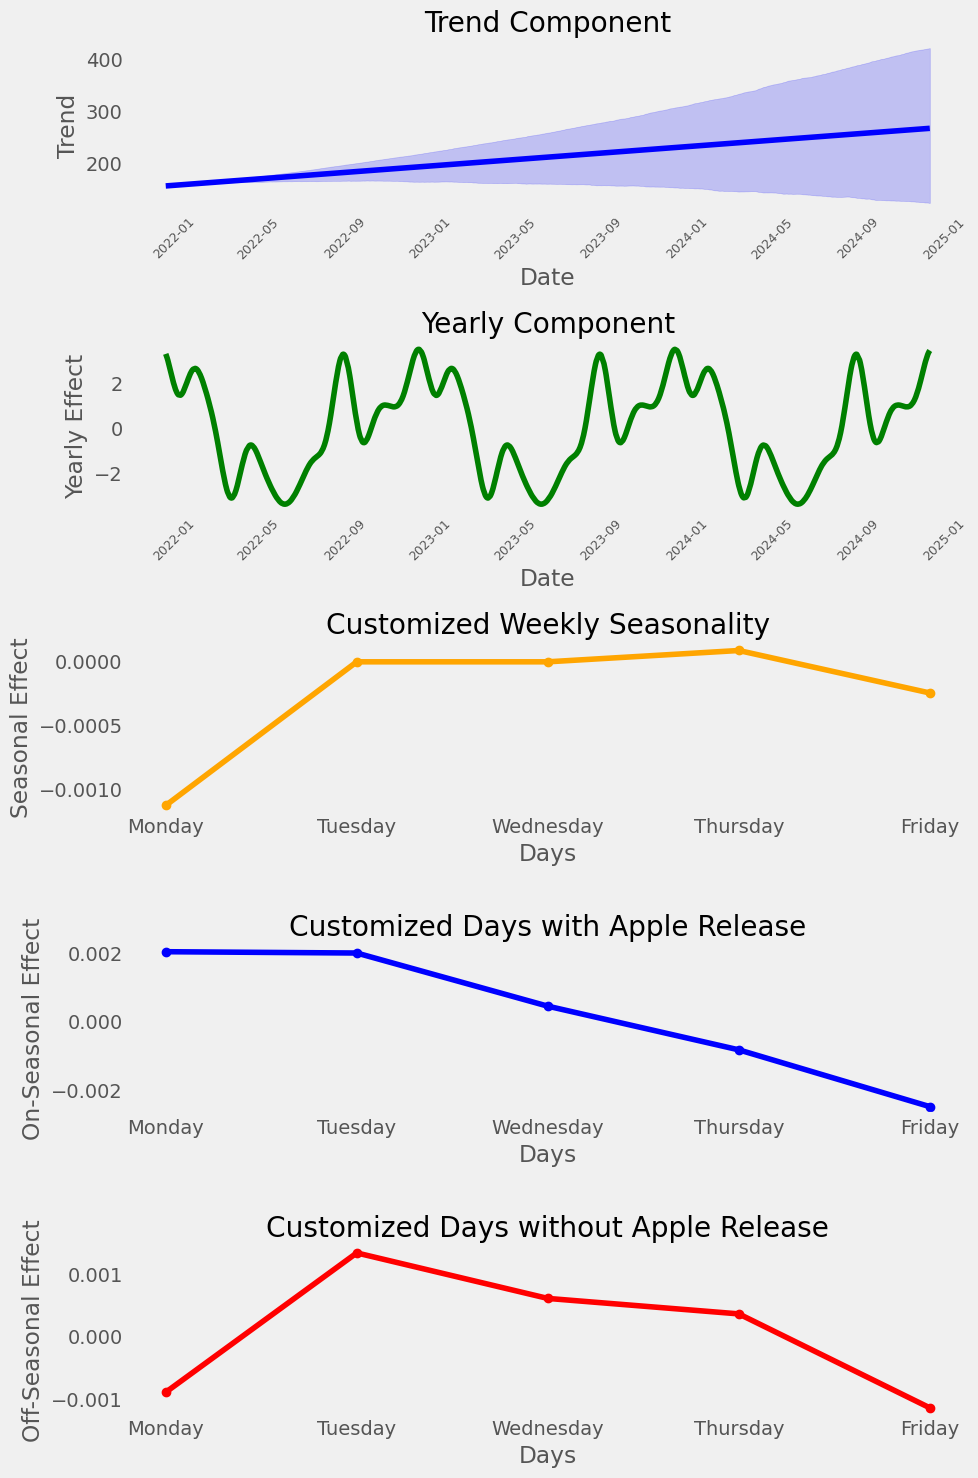

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract specific components from the forecast
trend = preds_Us_holiday[['ds', 'trend', 'trend_lower', 'trend_upper']]
yearly = preds_Us_holiday[['ds', 'yearly', 'yearly_lower', 'yearly_upper']]

# Create subplots for Trend, Seasonal, Weekly, and Customized Days
fig, axes = plt.subplots(5, 1, figsize=(10, 15))

# 1. Trend with Confidence Intervals
axes[0].plot(trend['ds'], trend['trend'], label='Trend', color='blue')
axes[0].fill_between(trend['ds'], trend['trend_lower'], trend['trend_upper'], color='blue', alpha=0.2, label='CI')
axes[0].set_title('Trend Component')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Trend')
axes[0].grid()
axes[0].tick_params(axis='x', rotation=45, labelsize=9)

# 2. Yearly Seasonality with Confidence Intervals
axes[1].plot(yearly['ds'], yearly['yearly'], label='Yearly Seasonality', color='green')
axes[1].fill_between(yearly['ds'], yearly['yearly_lower'], yearly['yearly_upper'], color='green', alpha=0.2, label='CI')
axes[1].set_title('Yearly Component')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Yearly Effect')
axes[1].grid()
axes[1].tick_params(axis='x', rotation=45, labelsize=9)

# Filter data for Monday to Friday (customized weekly effects)
preds_weekly = preds_Us_holiday[preds_Us_holiday['ds'].dt.weekday < 5]

# 3. Customized Weekly Seasonality (Monday to Friday)
days = np.arange(0, 5)  # Monday (0) to Friday (4)
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

weekly_effect = preds_weekly.groupby(preds_weekly['ds'].dt.weekday)['weekday_only'].mean()

axes[2].plot(days, weekly_effect, marker='o', label='Weekly Seasonality', color='orange')
axes[2].set_xticks(days)
axes[2].set_xticklabels(day_labels)
axes[2].set_title('Customized Weekly Seasonality')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Seasonal Effect')
axes[2].grid()

# 4. Customized Days with Apple Release (Monday to Friday)
on_season_effect = preds_weekly.groupby(preds_weekly['ds'].dt.weekday)['weekly_on_season'].mean()

axes[3].plot(days, on_season_effect, marker='o', label='On-Season Effect', color='blue')
axes[3].set_xticks(days)
axes[3].set_xticklabels(day_labels)
axes[3].set_title('Customized Days with Apple Release')
axes[3].set_xlabel('Days')
axes[3].set_ylabel('On-Seasonal Effect')
axes[3].grid()

# 5. Customized Days without Apple Release (Monday to Friday)
off_season_effect = preds_weekly.groupby(preds_weekly['ds'].dt.weekday)['weekly_off_season'].mean()

axes[4].plot(days, off_season_effect, marker='o', label='Off-Season Effect', color='red')
axes[4].set_xticks(days)
axes[4].set_xticklabels(day_labels)
axes[4].set_title('Customized Days without Apple Release')
axes[4].set_xlabel('Days')
axes[4].set_ylabel('Off-Seasonal Effect')
axes[4].grid()

# Adjust layout
plt.tight_layout()
plt.show()


**Seems the release days lead to a higher pick and lower decrease**

### Forecast

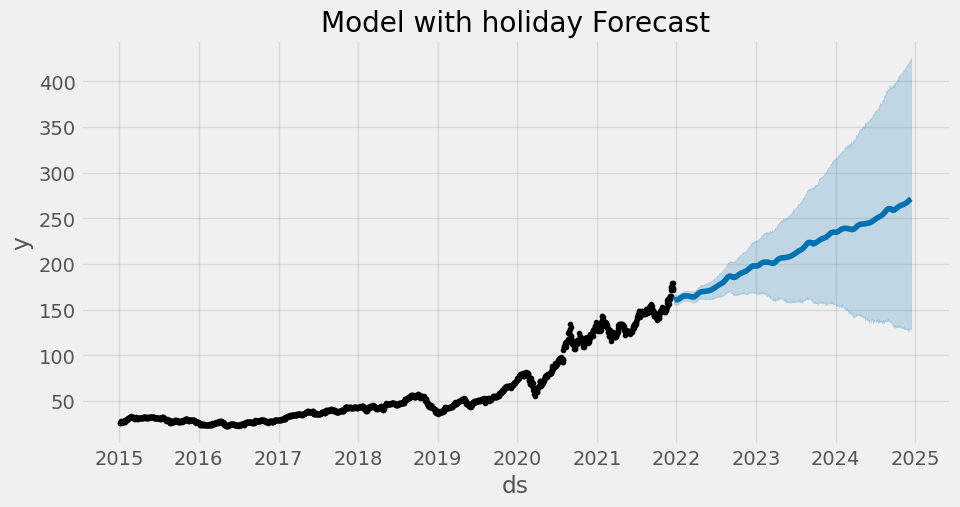

In [377]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = stocks_Us_holidays.plot(preds_Us_holiday, ax=ax)
ax.set_title('Model with holiday Forecast')
plt.show()

### Real Close vs Predicted

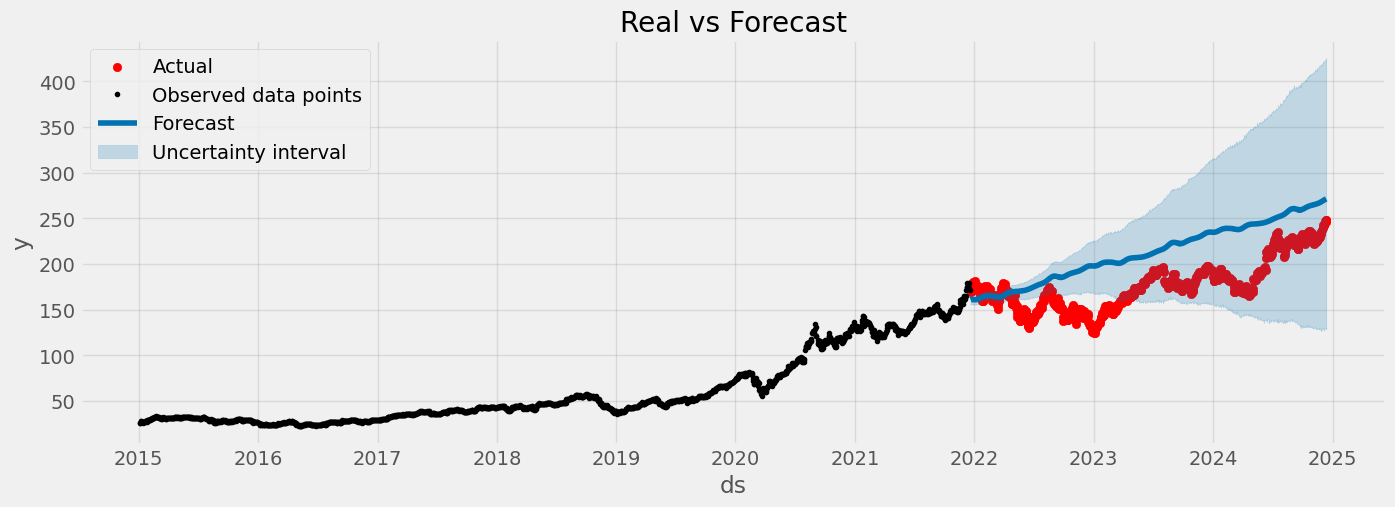

In [379]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Close_daily'], color = 'r', label = 'Actual')
fig = stocks_Us_holidays.plot(preds_Us_holiday, ax=ax)
plt.title('Real vs Forecast')
plt.legend()

## test dates

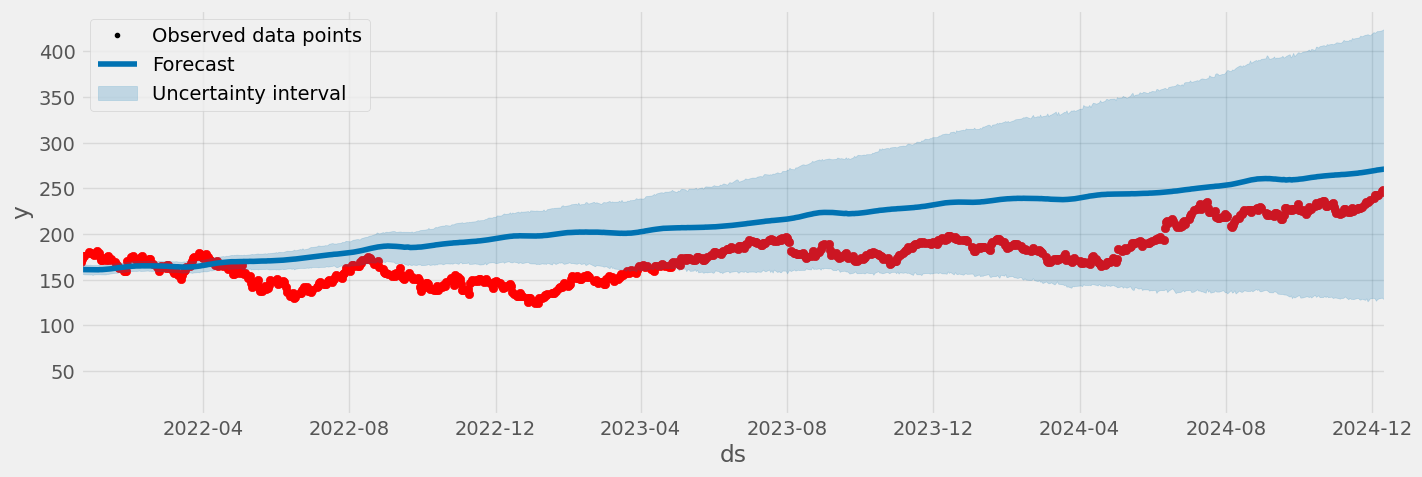

In [329]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Close_daily'], color = 'r')
fig = stocks_Us_holidays.plot(preds_Us_holiday, ax=ax)
ax.set_xbound(lower=apple_test_intra.index.min(),
              upper=apple_test_intra.index.max())
plt.legend()

## Preds histogram

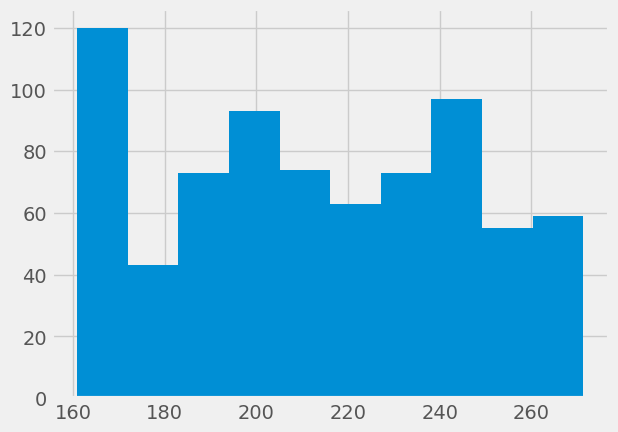

In [157]:
plt.hist(preds_Us_holiday['yhat']);

## Future Predictions

In [343]:
future_intra_holiday = stocks_Us_holidays.make_future_dataframe(periods=365*5, freq='d', include_history=False)
test_data_regres.set_index('ds', inplace=True)

future_intra_holiday['on_season'] = future_intra_holiday['ds'].apply(is_iphone_release_season)
future_intra_holiday['off_season'] = ~future_intra_holiday['on_season']
forecast_intra_holiday = stocks_Us_holidays.predict(future_intra_holiday)
forecast_intra_holiday['ds'] = pd.to_datetime(forecast_intra_holiday['ds'])
future_close = forecast_intra_holiday[forecast_intra_holiday['ds'] > test_data_regres.index.max()]

In [345]:
future_close.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekday_only,...,weekly_on_season,weekly_on_season_lower,weekly_on_season_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1078,2024-11-30,266.685988,125.003348,423.730031,121.727705,421.601631,2.326339,2.326339,2.326339,-0.002105,...,0.0,0.0,0.0,2.238188,2.238188,2.238188,0.0,0.0,0.0,269.012327
1079,2024-12-01,266.787151,120.306644,425.951430,121.686214,421.962083,2.372298,2.372298,2.372298,-0.036845,...,0.0,0.0,0.0,2.364061,2.364061,2.364061,0.0,0.0,0.0,269.159449
1080,2024-12-02,266.888315,127.705976,424.652151,121.644723,422.322536,2.492097,2.492097,2.492097,0.100108,...,0.0,0.0,0.0,2.490387,2.490387,2.490387,0.0,0.0,0.0,269.380412
1081,2024-12-03,266.989478,123.242779,425.281633,121.603232,422.682988,2.550274,2.550274,2.550274,0.011685,...,0.0,0.0,0.0,2.615709,2.615709,2.615709,0.0,0.0,0.0,269.539752
1082,2024-12-04,267.090642,123.945450,427.258072,121.561741,423.043440,2.705836,2.705836,2.705836,-0.072843,...,0.0,0.0,0.0,2.738500,2.738500,2.738500,0.0,0.0,0.0,269.796478


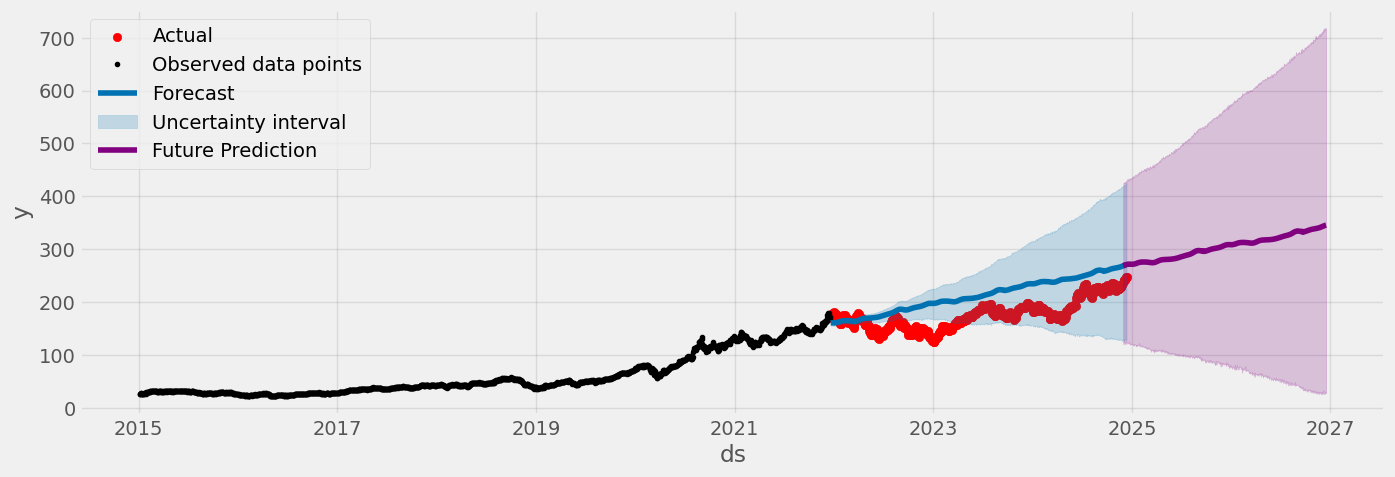

In [346]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Close_daily'], color = 'r', label = 'Actual')
fig = stocks_Us_holidays.plot(preds_Us_holiday, ax=ax)
sns.lineplot(x = future_close['ds'],y = future_close['yhat'], color = 'purple',label='Future Prediction')
ax.fill_between(
    future_close['ds'].values,
    future_close['yhat_lower'],
    future_close['yhat_upper'],
    color='purple',
    alpha=0.2,
)


plt.legend(loc = 'upper left')

### Evaluate

In [169]:
from sklearn.metrics import mean_squared_error
mse_intra_apple_holiday = mean_squared_error(test_subset_intra['y'],preds_Us_holiday['yhat'])
mse_intra_apple_holiday

1696.2083882205707

**Increased MSE, We can think about other events to add to the model**

### Error analysis

## Error Analysis

In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(stocks_Us_holidays, initial='730 days', period='30 days', horizon = '365 days') # Starting 730 days from start, making predictions every 5 days over a year


In [365]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,61.479934,7.840914,5.572634,0.092050,0.074411,0.091748,0.266837
1,38 days,62.791939,7.924136,5.637285,0.093158,0.074914,0.092870,0.261077
2,39 days,64.359874,8.022461,5.714545,0.094275,0.075899,0.093996,0.254703
3,40 days,65.723446,8.107000,5.782530,0.095328,0.077230,0.095013,0.250507
4,41 days,67.228050,8.199271,5.862136,0.096463,0.077783,0.096141,0.246347


In [366]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
324,361 days,588.726529,24.263687,18.165338,0.217825,0.177150,0.243119,0.377296
325,362 days,591.734235,24.325588,18.180373,0.217856,0.176996,0.243350,0.379206
326,363 days,593.448241,24.360793,18.211944,0.218388,0.177108,0.243973,0.379723
327,364 days,593.926050,24.370598,18.220392,0.218394,0.177386,0.244021,0.382592
328,365 days,597.685978,24.447617,18.266525,0.218626,0.177108,0.244462,0.385409


### Plotting smape metric over different windows

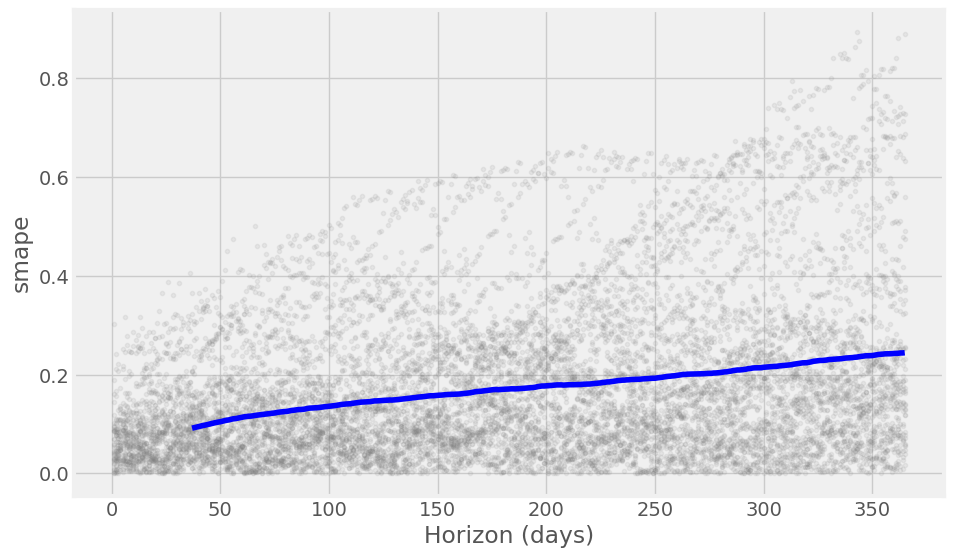

In [367]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='smape');


**Seems like the model doesn't have problematic windows when looking at monthly prediction. Can be investigated further**

<hr style="border:3px solid gray"> </hr>

# **Conclusions on apple stock models**

### Adding Holidays:

### Percentage of increase in MSE

In [173]:
(mse_intra_apple_holiday - mse_intra_apple)/mse_intra_apple * 100

1.430866938266666

In [174]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(apple_preds_intra['yhat'], preds_Us_holiday['yhat'])
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")


T-statistic: -0.185, P-value: 0.854


*Adding Us Holidays did not improve the model, it made it slightly worse with no significant difference*

<br>

***

### Adding Fama & French Factors

##### Looking at common observations

In [250]:
max_test_date = test_data_regres['ds'].max()

test_subset_intra_matched = test_subset_intra[test_subset_intra['ds'] <= max_test_date]
apple_preds_intra_matched = apple_preds_intra[apple_preds_intra['ds'] <= max_test_date]


mse_intra_apple_trunc = mean_squared_error(
    test_subset_intra_matched['y'],  # True values
    apple_preds_intra_matched['yhat']  # Predicted values
)

print("Mean Squared Error (Aligned):", mse_intra_apple_trunc)

Mean Squared Error (Aligned): 1684.6723991391475


### Percentage of decrease in MSE

In [251]:
(mse_intra_apple_trunc - mse_intra_apple_regres)/mse_intra_apple_trunc * 100

7.262292557263416

In [253]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(apple_preds_intra_matched['yhat'], stock_regress_preds['yhat'])
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")


T-statistic: 0.894, P-value: 0.371


*Adding Fama & French improved the model with a non significant effect, but it can have a substantial effect*


<hr style="border:3px solid gray"> </hr>

# **Summary**

**Adjusting the model to a 5-day span (Monday to Friday) resulted in improved performance, which aligns with the nature of our stock data. However, incorporating iPhone release dates did not enhance prediction accuracy, and adding U.S. holidays significantly worsened the model's performance. We can look into adding different recurring events**

**On the other hand, including external regressors, such as F&F factors, yielded a slight improvement in model accuracy, though the impact was not substantial.**

**Moving forward, we can explore incorporating additional time-dependent events and experimenting with different regressors to further enhance the model's predictive capabilities**

